In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '6'
import sys

from scripts.dataset import *
from scripts.algorithms import *

import warnings
warnings.filterwarnings('ignore')

## GENERATE DATASET

In [2]:
items = ['Orange', 'Kiwi', 'Apple', 'Melon', 'Peach', 'Pear', 'Avocado', 'Pineapple']
probability = [10, 1, 1, 1, 1, 1, 1, 1]
max_items = 5
length = 10

# Create dataset
arr = generate_arr(items, probability, max_items=max_items, length=length) # , mode='rand')
df = pd.DataFrame(data=arr, columns=[f'Item {x}' for x in range(1, max([len(x) for x in arr])+1)])
print('Shape:', df.shape)
display(df)

# Show transformed dataset
new_df = transform_arr(df, items)
display(new_df.head(5))

Shape: (10, 4)


,Item 1,Item 2,Item 3,Item 4
0,Orange,None,None,None
1,Orange,Kiwi,Pineapple,Peach
2,Orange,Avocado,Melon,Pineapple
3,Melon,Apple,None,None
4,Melon,Pear,None,None
5,Apple,None,None,None
6,Orange,None,None,None
7,Orange,Peach,None,None
8,Orange,Melon,Pineapple,Kiwi
9,Orange,Melon,None,None


,Orange,Kiwi,Apple,Melon,Peach,Pear,Avocado,Pineapple
0,True,False,False,False,False,False,False,False
1,True,True,False,False,True,False,False,True
2,True,False,False,True,False,False,True,True
3,False,False,True,True,False,False,False,False
4,False,False,False,True,False,True,False,False


## ONE-HOT ENCODING

In [3]:
# One-Hot Encoding
onehot_df = onehot_encoder(arr)

Length: 10


,Apple,Avocado,Kiwi,Melon,Orange,Peach,Pear,Pineapple
0,False,False,False,False,True,False,False,False
1,False,False,True,False,True,True,False,True
2,False,True,False,True,True,False,False,True
3,True,False,False,True,False,False,False,False
4,False,False,False,True,False,False,True,False


## APRIORI

In [4]:
# Apiori
apriori_fpgrowth_mlxtend(onehot_df, mode='apriori', min_support=0.30, min_metric=0.50)

,support,itemsets
0,0.7,(Orange)
1,0.5,(Melon)
2,0.3,(Pineapple)
3,0.3,"(Orange, Melon)"
4,0.3,"(Pineapple, Orange)"


Shape: (2, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Pineapple),(Orange),0.3,0.7,0.3,1.0,1.428571,0.09,inf
1,(Melon),(Orange),0.5,0.7,0.3,0.6,0.857143,-0.05,0.75


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Pineapple),(Orange),0.3,0.7,0.3,1.0,1.428571,0.09,inf
1,(Melon),(Orange),0.5,0.7,0.3,0.6,0.857143,-0.05,0.75


## ECLAT

In [5]:
# List the transactions and items
dataset = [[f'T{x+1}', ', '.join(y)] for x, y in enumerate(arr)]
dataset_df = pd.DataFrame(dataset, columns=['transactions', 'items'])
display(dataset_df)

,transactions,items
0,T1,Orange
1,T2,"Orange, Kiwi, Pineapple, Peach"
2,T3,"Orange, Avocado, Melon, Pineapple"
3,T4,"Melon, Apple"
4,T5,"Melon, Pear"
5,T6,Apple
6,T7,Orange
7,T8,"Orange, Peach"
8,T9,"Orange, Melon, Pineapple, Kiwi"
9,T10,"Orange, Melon"


In [6]:
# Create list of possible combinations
dataset_items = [item for sublist in arr for item in sublist]
L = [x+1 for x in range(df.shape[1])]

dataset_set = list()
for x in L:
    sets = combinations(set(dataset_items), r=x)
    dataset_set.extend(sets)
dataset_set = [list(x) for x in dataset_set]
print('Length:', len(dataset_set))
display(pd.DataFrame(dataset_set).head(5))

Length: 162


,0,1,2,3
0,Orange,None,None,None
1,Apple,None,None,None
2,Kiwi,None,None,None
3,Pear,None,None,None
4,Pineapple,None,None,None


In [7]:
# Change the dataset format for ECLAT algorithm, calculate support
transactions_list = list()
counts_list = list()
for item in dataset_set:
    transactions = list()
    count = 0
    for index, row in dataset_df.iterrows():
        if set(item).issubset(set(row[1].split(', '))):
            transactions.append(f'T{index+1}')
            count += 1
    transactions_list.append(transactions)
    counts_list.append(count)

eclat_df = pd.DataFrame({'items': [' & '.join(x) for x in dataset_set],
        'antecedents': [x[0] for x in dataset_set],
        'consequents': [x[1] if len(x) == 2 else None for x in dataset_set],
        'transactions': [', '.join(x) for x in transactions_list],
        'support': [x/len(arr) for x in counts_list],    # Divide by number of transactions
        'count': counts_list})

eclat_df = eclat_df[eclat_df['transactions'].astype(bool)]  # Drop empty transactions
eclat_df = eclat_df[eclat_df['support'] >= 0.30].reset_index(drop=True)    # Set minimum support as 0.20

print('Shape:', eclat_df.shape)
display(eclat_df.head(5))
display(eclat_df.tail(5))

Shape: (5, 6)


,items,antecedents,consequents,transactions,support,count
0,Orange,Orange,None,"T1, T2, T3, T7, T8, T9, T10",0.7,7
1,Pineapple,Pineapple,None,"T2, T3, T9",0.3,3
2,Melon,Melon,None,"T3, T4, T5, T9, T10",0.5,5
3,Orange & Pineapple,Orange,Pineapple,"T2, T3, T9",0.3,3
4,Orange & Melon,Orange,Melon,"T3, T9, T10",0.3,3


,items,antecedents,consequents,transactions,support,count
0,Orange,Orange,None,"T1, T2, T3, T7, T8, T9, T10",0.7,7
1,Pineapple,Pineapple,None,"T2, T3, T9",0.3,3
2,Melon,Melon,None,"T3, T4, T5, T9, T10",0.5,5
3,Orange & Pineapple,Orange,Pineapple,"T2, T3, T9",0.3,3
4,Orange & Melon,Orange,Melon,"T3, T9, T10",0.3,3


In [8]:
# Transform dataset
eclat_df['x_count'] = [eclat_df.at[eclat_df.index[eclat_df['items'] == x][0], 'count'] for x in eclat_df['antecedents']]
eclat_df['y_count'] = [eclat_df.at[eclat_df.index[eclat_df['items'] == x][0], 'count'] if x else None for x in eclat_df['consequents']]
eclat_df['x_support'] = eclat_df['x_count']/len(arr)
eclat_df['y_support'] = eclat_df['y_count']/len(arr)

# Calculate confidence
eclat_df['confidence'] = 0
for x in range(len(eclat_df)):
    eclat_df.loc[x, 'confidence'] = round(eclat_df.loc[x, 'count']/eclat_df.loc[x, 'x_count'], 4)
eclat_df = eclat_df.sort_values(by='confidence', ascending=False).reset_index(drop=True)

# Calculate lift
eclat_df['lift'] = 0
for x in range(len(eclat_df)):
    eclat_df.loc[x, 'lift'] = round(eclat_df.loc[x, 'confidence']/eclat_df.loc[x, 'y_support'], 4)

# Filter L = 2
# eclat_df = eclat_df[eclat_df['consequents'].astype(bool)].reset_index(drop=True)

print('Length:', len(eclat_df))
display(eclat_df)

Length: 5


,items,antecedents,consequents,transactions,support,count,x_count,y_count,x_support,y_support,confidence,lift
0,Orange,Orange,None,"T1, T2, T3, T7, T8, T9, T10",0.7,7,7,NaN,0.7,NaN,1.0000,NaN
1,Pineapple,Pineapple,None,"T2, T3, T9",0.3,3,3,NaN,0.3,NaN,1.0000,NaN
2,Melon,Melon,None,"T3, T4, T5, T9, T10",0.5,5,5,NaN,0.5,NaN,1.0000,NaN
3,Orange & Pineapple,Orange,Pineapple,"T2, T3, T9",0.3,3,7,3.0,0.7,0.3,0.4286,1.4287
4,Orange & Melon,Orange,Melon,"T3, T9, T10",0.3,3,7,5.0,0.7,0.5,0.4286,0.8572


## FPGROWTH

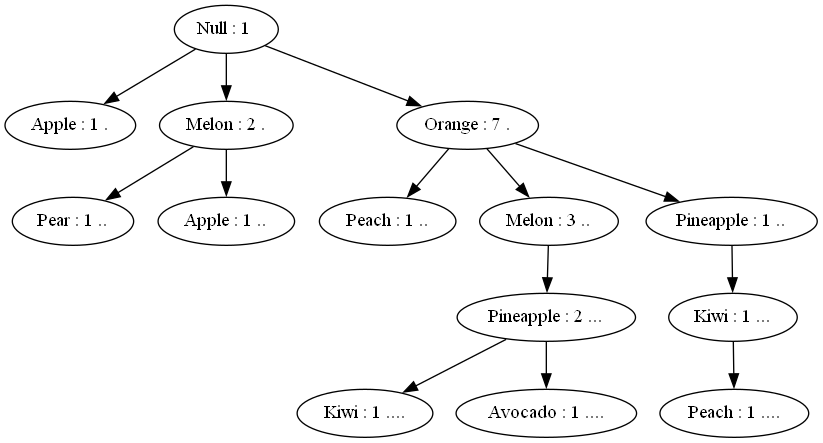

In [9]:
fpgrowth_python(arr)

## TREE GRAPH VISUALIZATION

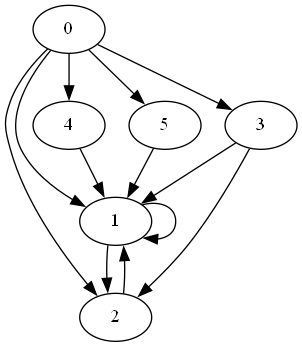

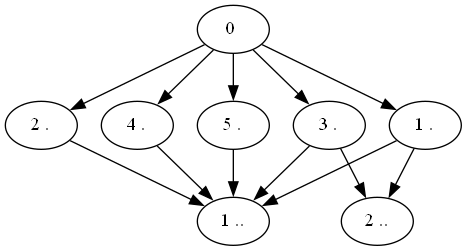

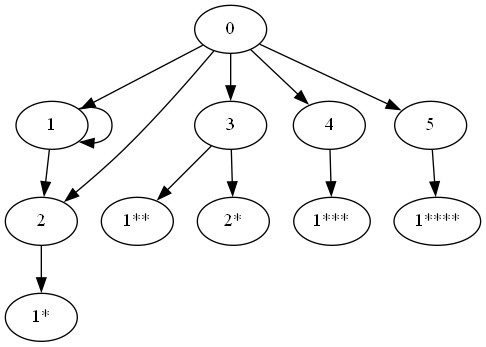

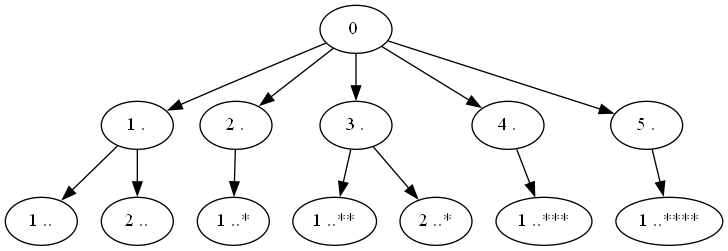

In [10]:
graph = '''
0
	1
		1
		2
	2
		1
	3
		1
		2
	4
		1
	5
		1
'''

# Level and Duplicates are not included
fpgrowth_graph(graph.lstrip('\n'), include_level=False, include_duplicates=False)

# Level is included
fpgrowth_graph(graph.lstrip('\n'), include_level=True, include_duplicates=False)

# Duplicates are included
fpgrowth_graph(graph.lstrip('\n'), include_level=False, include_duplicates=True)

# Level and Duplicates are included
fpgrowth_graph(graph.lstrip('\n'), include_level=True, include_duplicates=True)